### Problem Statement
To build a CNN based model which can accurately detect Melanoma. Melanoma is a type of skin cancer which can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

#### Dataset
This notebook uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directions in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

# 1. Importing all the relevant libraries

In [1]:
import os
import PIL
import random
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,  BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers.experimental import preprocessing
from glob import glob
import Augmentor

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path(os.getcwd()+r"\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train")
data_dir_test = pathlib.Path(os.getcwd()+r"\\Skin cancer ISIC The International Skin Imaging Collaboration\\Test")

In [3]:
# Checking the count of images in order to make sure all the data has been ingested
image_count_train = len(list(data_dir_train.glob("*/*.jpg")))
print("Train: ", image_count_train)
image_count_test = len(list(data_dir_test.glob("*/*.jpg")))
print("Test: ", image_count_test)

Train:  2239
Test:  118


## 2. Creating the dataset

In [4]:
# Defining the parameter for the loader
batch_size = 32
img_height = 180
img_width = 180
num_classes = 9

Using 75% images for training and 25% for validation

In [5]:
# Train Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train, batch_size=batch_size, image_size=(img_height, img_width),
            seed = 100, validation_split=0.25, subset="training")

Found 2239 files belonging to 9 classes.
Using 1680 files for training.


In [6]:
# Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
            data_dir_train, batch_size=batch_size, image_size=(img_height, img_width),
            seed = 100, validation_split=0.25, subset="validation")

Found 2239 files belonging to 9 classes.
Using 559 files for validation.


In [7]:
# Listing all the classes of skin cancer and storing them in a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## 3. Visualizing the dataset

In [8]:
list(enumerate(class_names))

[(0, 'actinic keratosis'),
 (1, 'basal cell carcinoma'),
 (2, 'dermatofibroma'),
 (3, 'melanoma'),
 (4, 'nevus'),
 (5, 'pigmented benign keratosis'),
 (6, 'seborrheic keratosis'),
 (7, 'squamous cell carcinoma'),
 (8, 'vascular lesion')]

In [9]:
class_path = pathlib.Path(os.getcwd()+ r"\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\" + "vascular lesion")

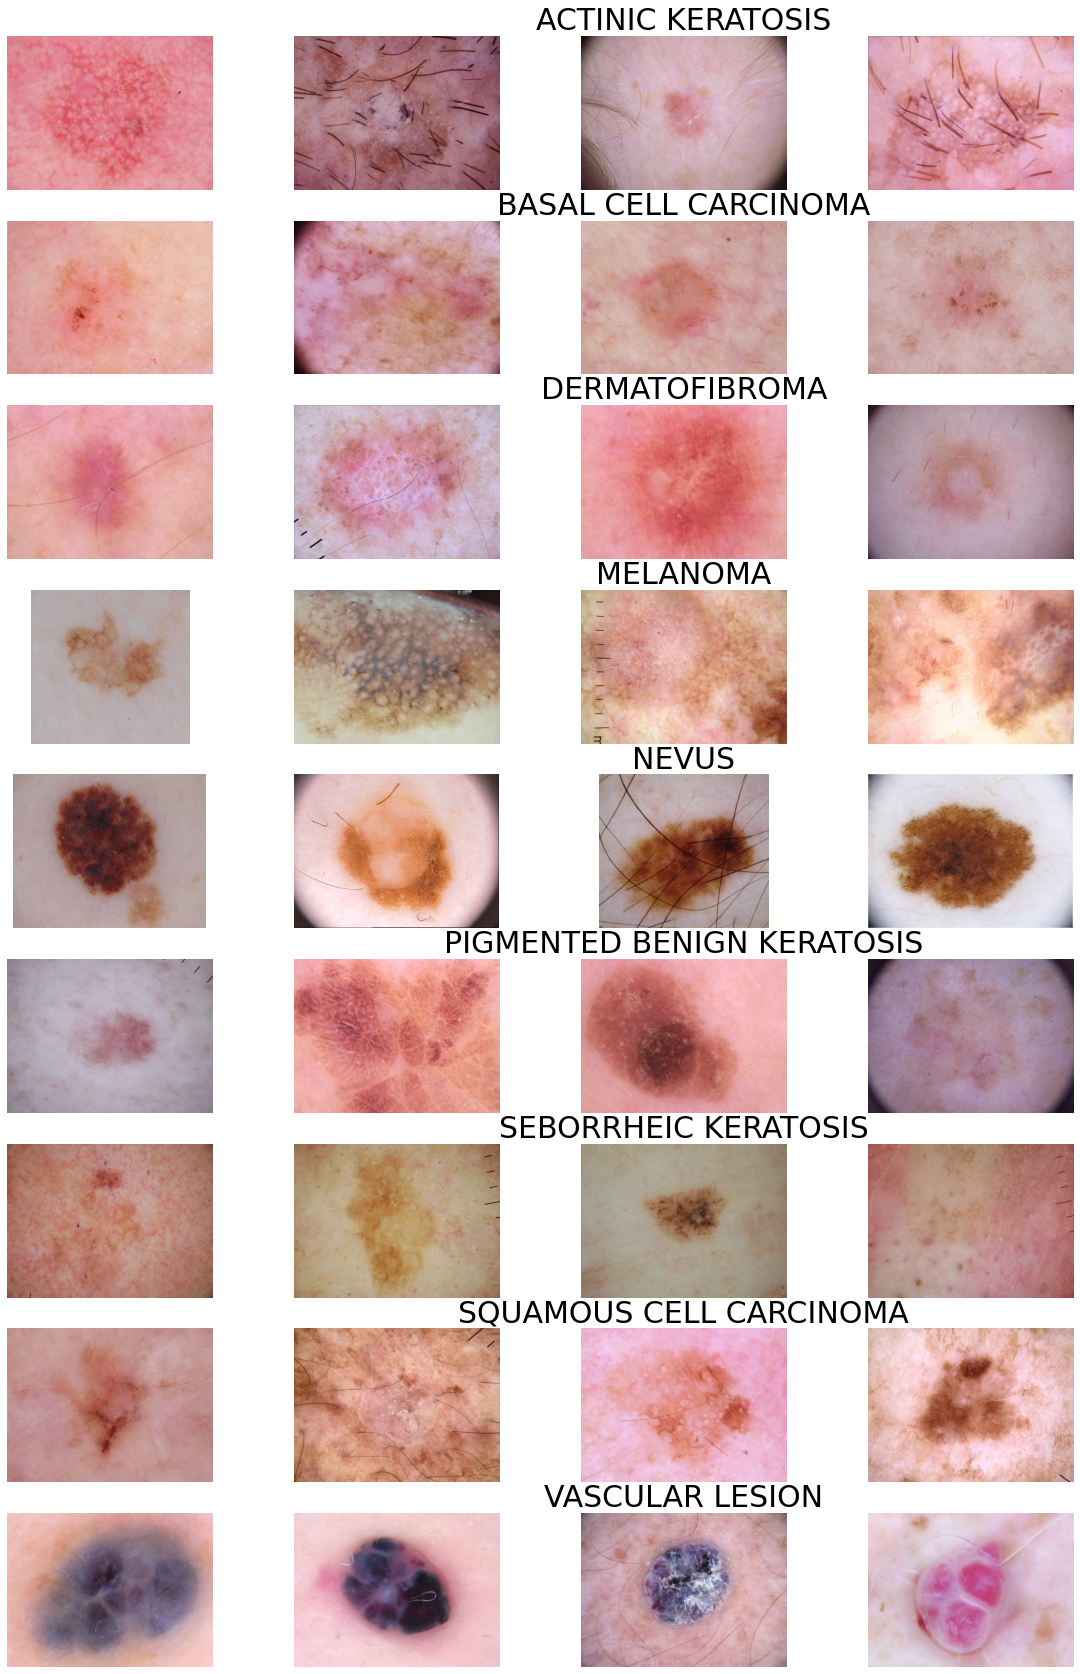

In [10]:
# Printing the 4 images from each class

plt.figure(figsize=(30,30))

for n, class_name in enumerate(class_names):
    class_path = pathlib.Path(os.getcwd()+ r"\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\" + class_name)
    
    path_list = [x for x in class_path.glob("*")]
    
    for img in range(4):
        ax = plt.subplot(9,6,6*n+img+1)
        m = random.randint(0,len(path_list)-1)
        image = mpimg.imread(path_list[m])
        plt.imshow(image)
        
        if img%4 == 2:
            plt.title(class_name.upper(), fontsize = 30)
        plt.axis("off")

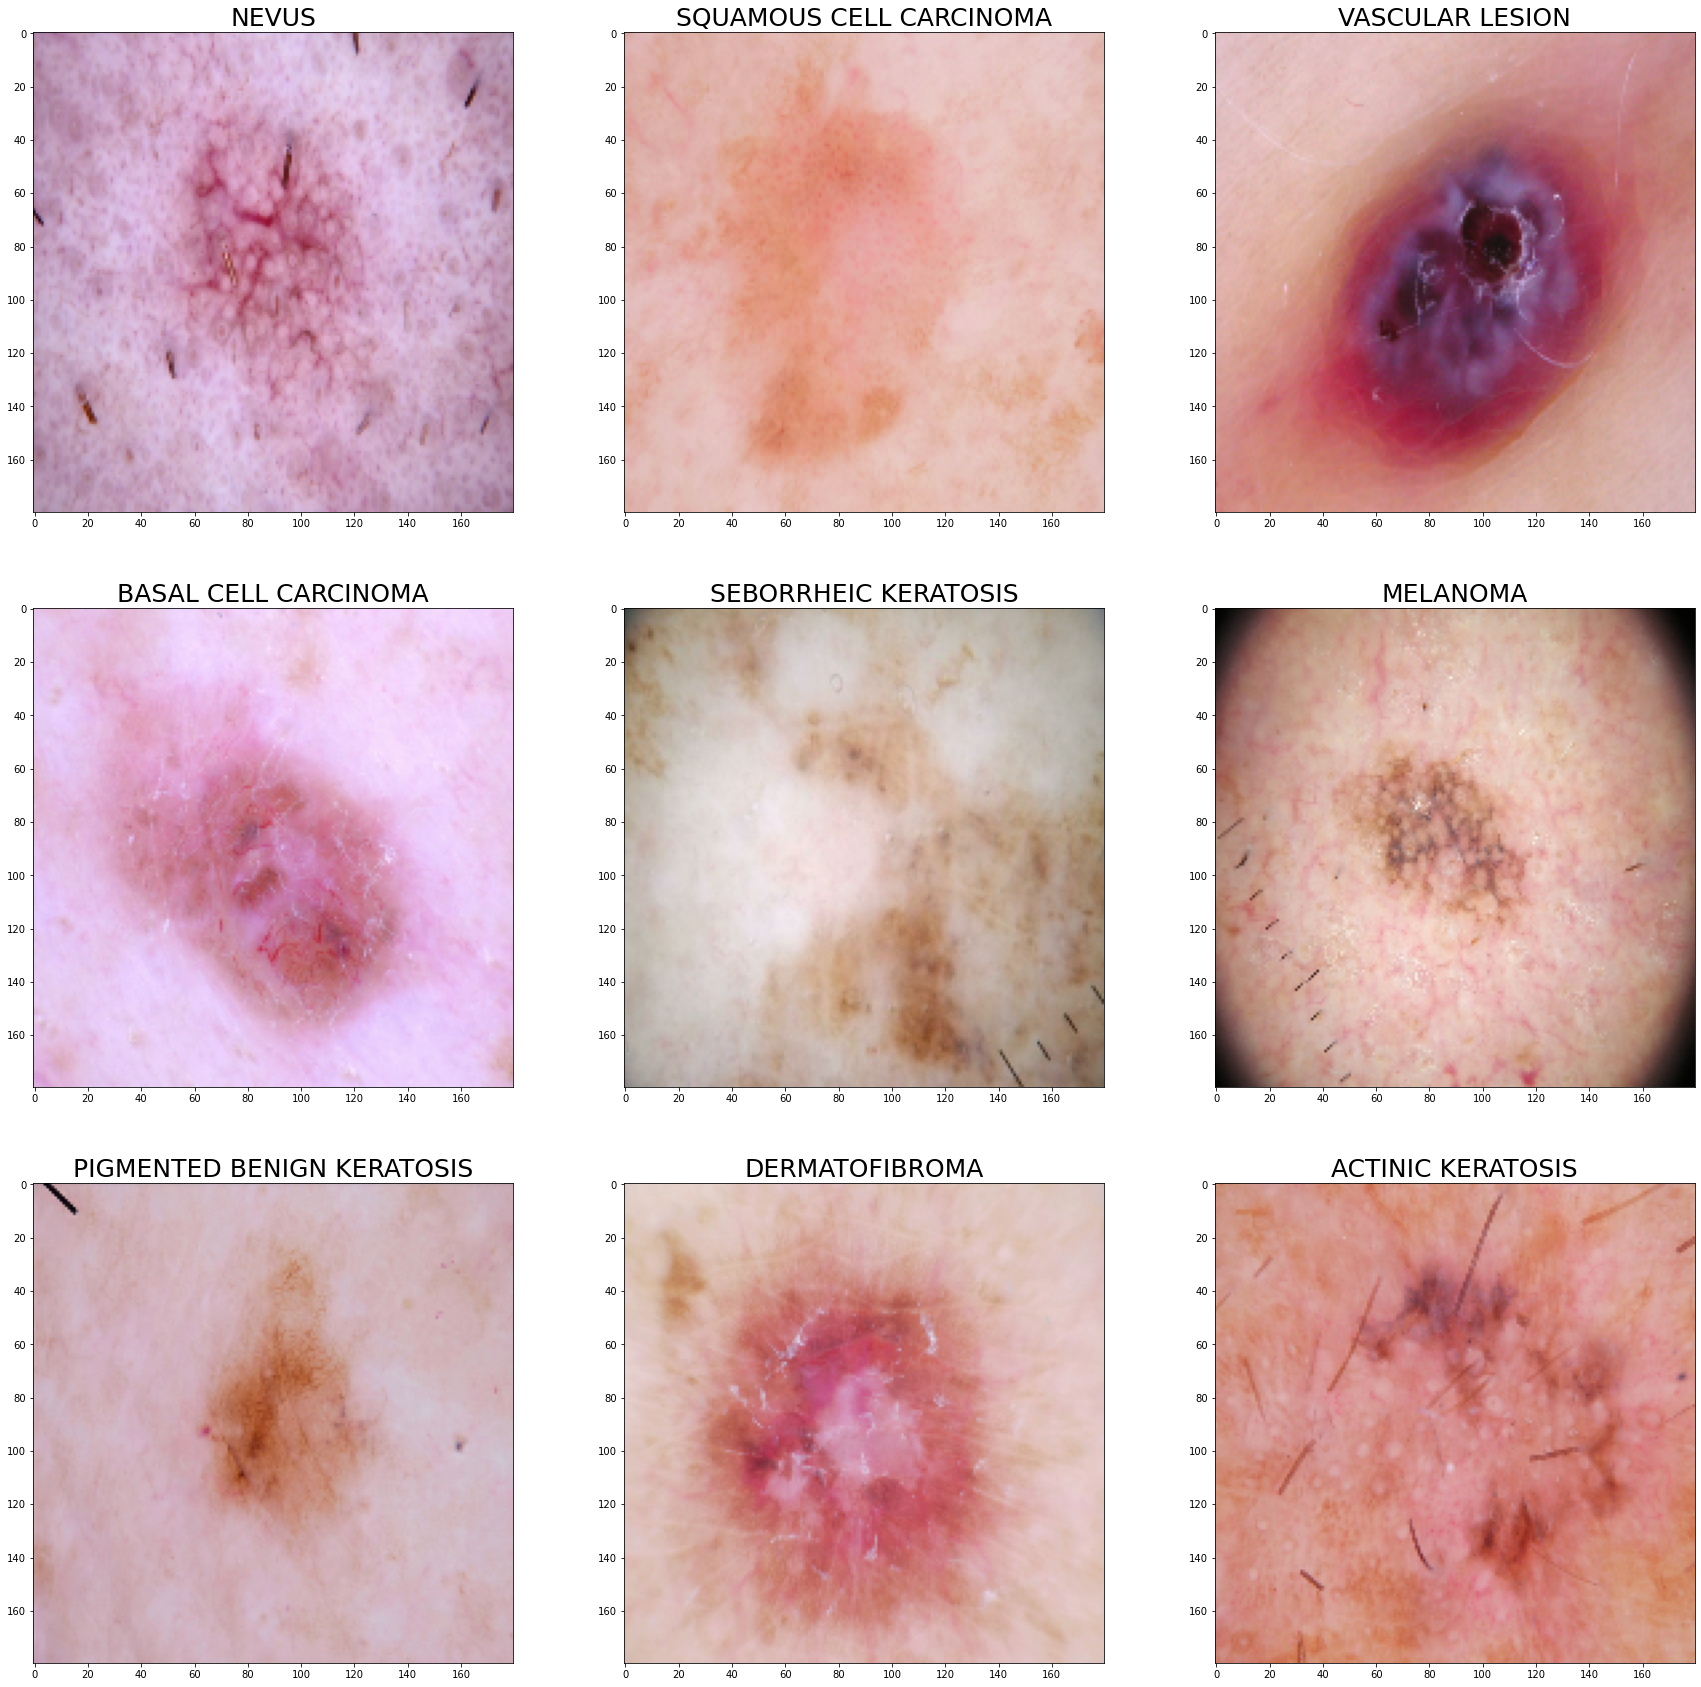

In [11]:
# Visualising the train dataset

classes = []
n=0
plt.figure(figsize=(30,30))
for img,lab in train_ds:
    for i in range(batch_size):
        if class_names[lab[i]] not in classes:
            classes.append(class_names[lab[i]])
            ax = plt.subplot(3,3,n+1)
            plt.imshow(img[i].numpy().astype("uint8"))
            plt.title(class_names[lab[i]].upper(), fontsize= 25)
            n+=1
    if len(classes) == len(class_names):
        break

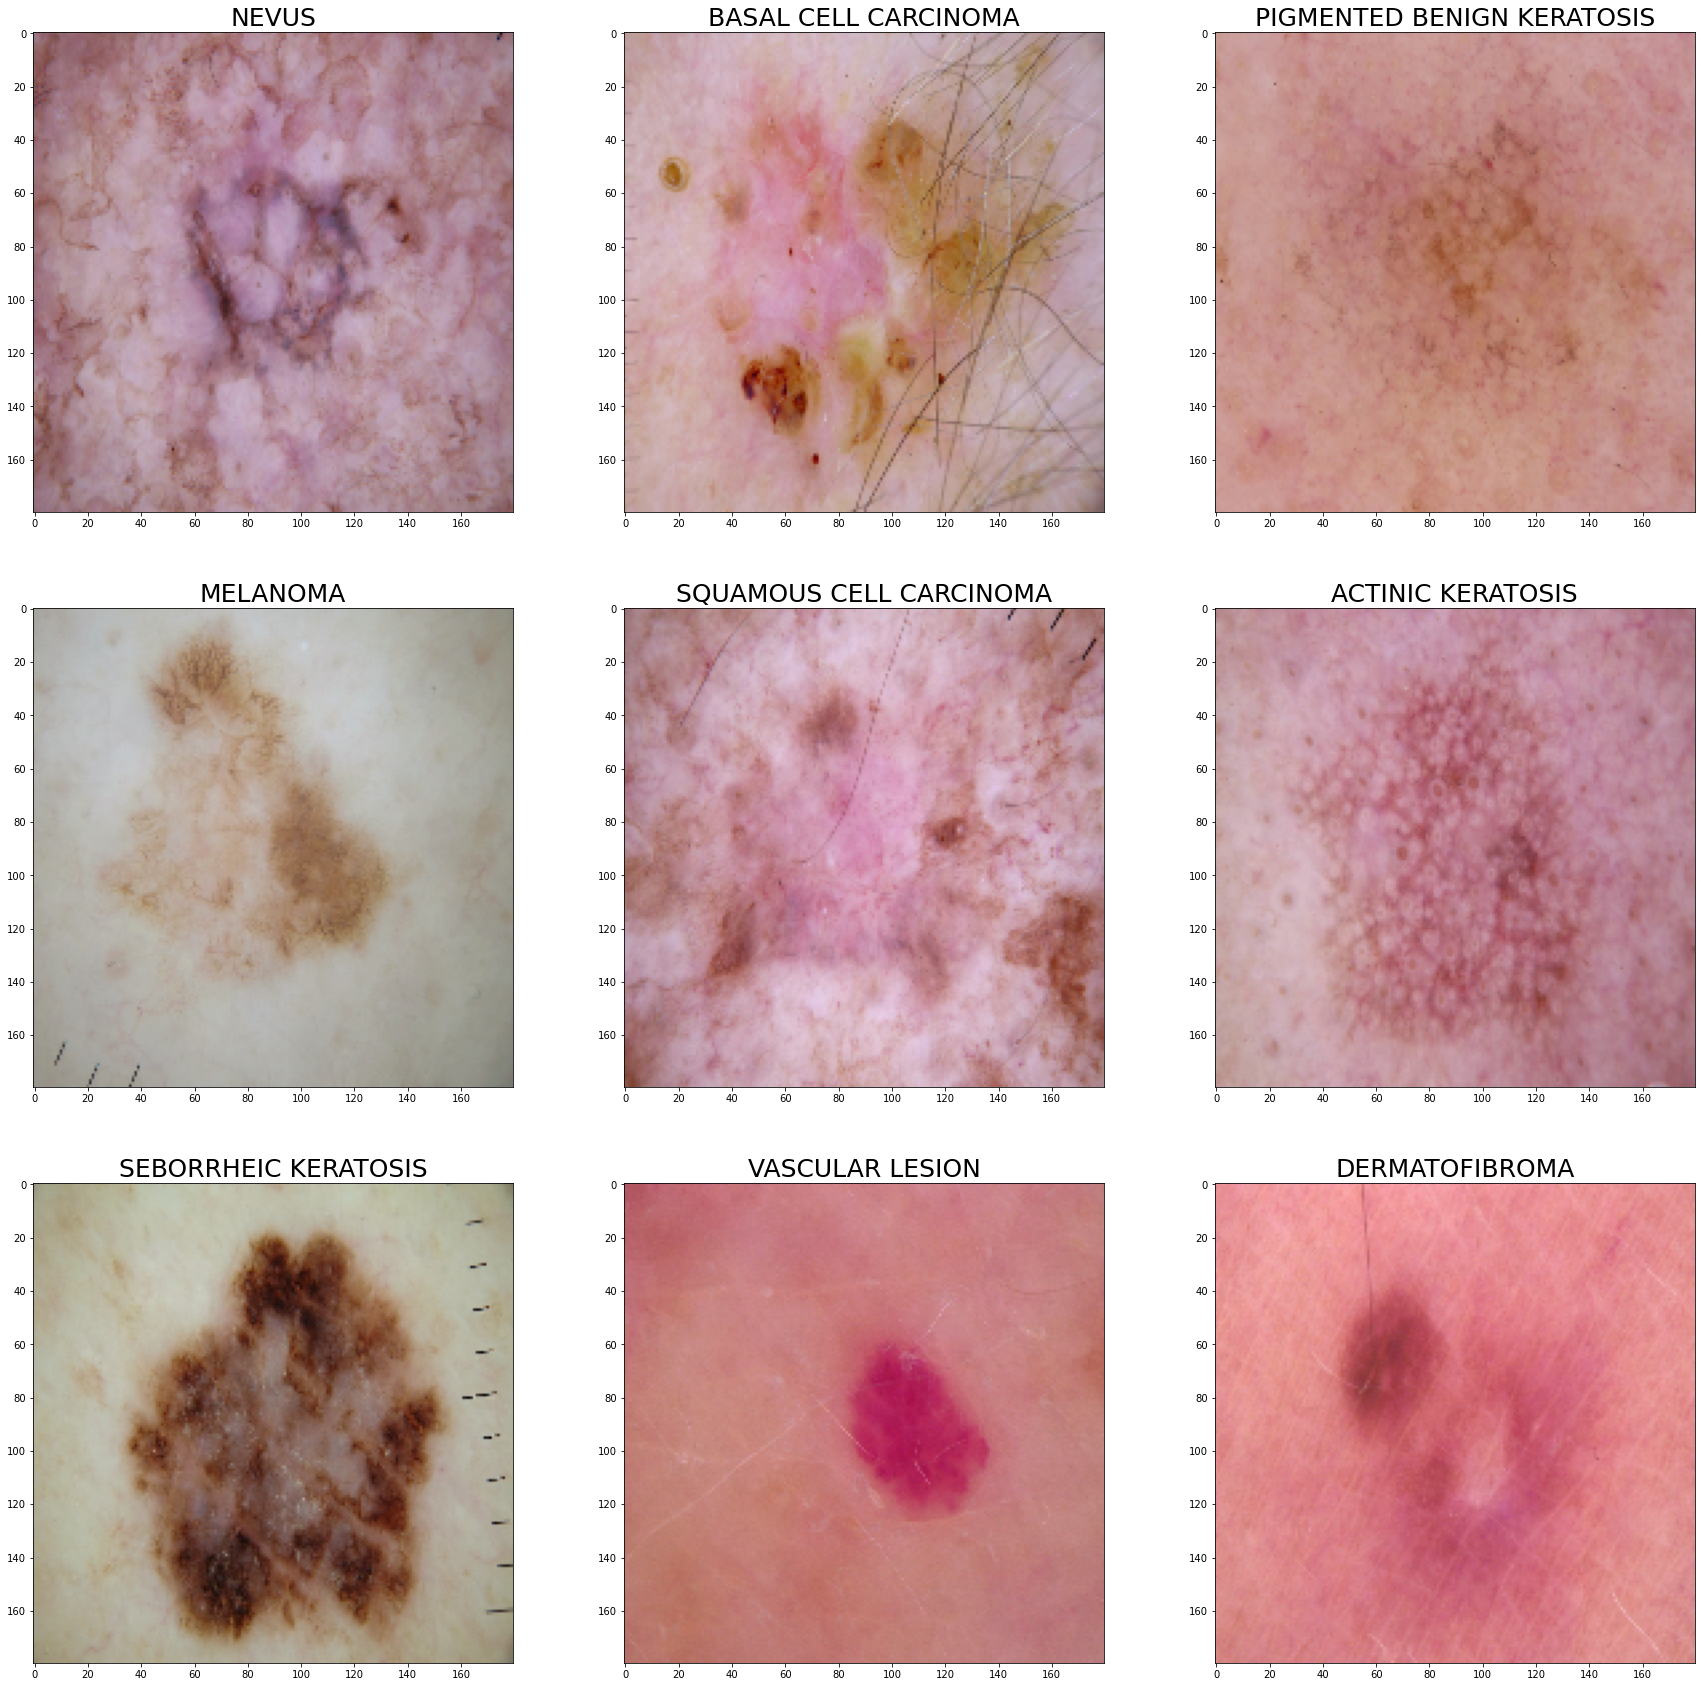

In [12]:
# Visualising the validation dataset

classes = []
n=0
plt.figure(figsize=(30,30))
for img,lab in val_ds:
    for i in range(batch_size):
        if class_names[lab[i]] not in classes:
            classes.append(class_names[lab[i]])
            ax = plt.subplot(3,3,n+1)
            plt.imshow(img[i].numpy().astype("uint8"))
            plt.title(class_names[lab[i]].upper(), fontsize= 25)
            n+=1
    if len(classes) == len(class_names):
        break

- The image_batch is a tensor of the shape (32,180,180,3). This is a batch of 32 images of shape 180x180x3.
- The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

- Dataset.cache() keeps the images in memory after they are loaded off the disk during the first epoch.
- Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [13]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# 2. Create the model

### First Basic Model

In [14]:
# Model
mod = Sequential()

# Rescaling the layer to normalize pixel values between (0,1)
mod.add(preprocessing.Rescaling(1.0/225, input_shape = (img_height,img_width,3)))

# Convolutional Layer - 1
mod.add(Conv2D(16, kernel_size=(3,3), activation="relu"))
# Pooling Layer - 1
mod.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional Layer - 2
mod.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
# Pooling Layer - 2
mod.add(MaxPooling2D(pool_size=(2,2)))

# Convolutional Layer - 3
mod.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
# Pooling Layer - 3
mod.add(MaxPooling2D(pool_size=(2,2)))

# Flattening and Putting fully connected layer
mod.add(Flatten())
mod.add(Dense(num_classes, activation="softmax"))

In [15]:
### Compiling the model

# Choosing appropriate optimiser and loss function for model training
mod.compile(optimizer="adam",
           loss=tf.keras.losses.sparse_categorical_crossentropy,
           metrics=["accuracy"])

In [16]:
# Summary
mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 64)        1

In [17]:
### Training the model

# Model training for 20 epochs
epochs = 20
history = mod.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
53/53 [==============================] - 16s 243ms/step - loss: 2.0448 - accuracy: 0.2220 - val_loss: 1.9798 - val_accuracy: 0.2451
Epoch 2/20
53/53 [==============================] - 12s 223ms/step - loss: 1.8265 - accuracy: 0.3077 - val_loss: 1.7365 - val_accuracy: 0.3918
Epoch 3/20
53/53 [==============================] - 12s 227ms/step - loss: 1.6271 - accuracy: 0.4310 - val_loss: 1.6027 - val_accuracy: 0.4705
Epoch 4/20
53/53 [==============================] - 12s 223ms/step - loss: 1.3805 - accuracy: 0.5304 - val_loss: 1.4537 - val_accuracy: 0.5134
Epoch 5/20
53/53 [==============================] - 12s 223ms/step - loss: 1.3093 - accuracy: 0.5548 - val_loss: 1.5266 - val_accuracy: 0.4669
Epoch 6/20
53/53 [==============================] - 12s 219ms/step - loss: 1.2503 - accuracy: 0.5613 - val_loss: 1.4331 - val_accuracy: 0.5206
Epoch 7/20
53/53 [==============================] - 12s 220ms/step - loss: 1.1170 - accuracy: 0.6077 - val_loss: 1.5086 - val_accuracy: 0.5224

`Inference:` We can see that the model is overfitting since, the training accuracy is 85% and validation accuracy is just 51%

### Visualizing the Training Results

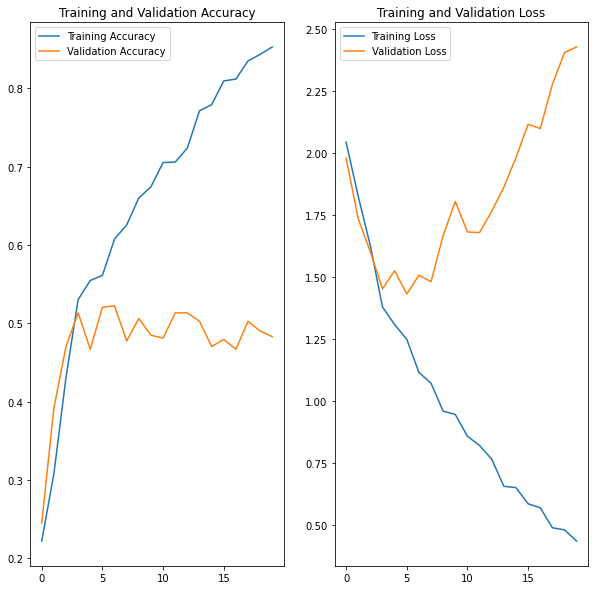

In [18]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(10,10))

# Accuracy Graph
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label= "Training Accuracy")
plt.plot(epochs_range, val_acc, label= "Validation Accuracy")
plt.legend(loc= "upper left")
plt.title("Training and Validation Accuracy")

# Loss Graph
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label= "Training Loss")
plt.plot(epochs_range, val_loss, label= "Validation Loss")
plt.legend(loc= "upper left")
plt.title("Training and Validation Loss")

plt.show()

`Inference:`
- We can see that Training Accuracy is clearly a lot higher than the validation accuracy.
- In the initial epoch, both accuracies were pretty close but after a few, they started moving apart.
- This seems to be happening if the model is too complex or the model is overfitting.

#### Data Augmentation Strategy

In [19]:
# Creating an augmentation layer to handle the overfitting detected above
data_augmentation = Sequential(
                    [
                        preprocessing.RandomFlip("horizontal", input_shape = (img_height, img_width,3)),
                        preprocessing.RandomRotation(0.2),
                        preprocessing.RandomZoom(0.2)
                    ])

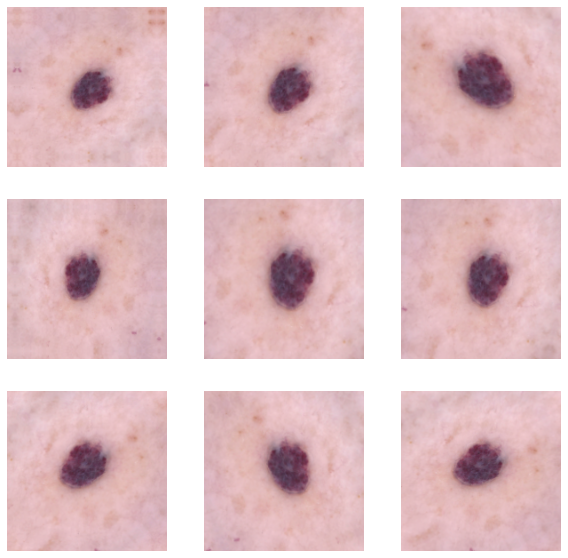

In [20]:
# Visualizing how the augmentation layer is working

plt.figure(figsize=(10,10))
for img, lad in train_ds.take(1):
    for i in range(9):
        augmented_img = data_augmentation(img)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_img[0].numpy().astype("uint8"))
        plt.axis("off")

### Second Model

In [21]:
# Model
mod = Sequential()

# Adding an augmentation layer to avoid overfitting
mod.add(data_augmentation)

# Rescaling the layer to normalize pixel values between (0,1)
mod.add(preprocessing.Rescaling(1.0/225, input_shape = (img_height,img_width,3)))

# Convolutional Layer - 1
mod.add(Conv2D(16, kernel_size=(3,3), activation="relu"))
# Pooling Layer - 1
mod.add(MaxPooling2D(pool_size=(2,2)))
# Dropout Layer - 1
mod.add(Dropout(0.25))

# Convolutional Layer - 2
mod.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
# Pooling Layer - 2
mod.add(MaxPooling2D(pool_size=(2,2)))
# Dropout Layer - 1
mod.add(Dropout(0.25))

# Convolutional Layer - 3
mod.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
# Pooling Layer - 3
mod.add(MaxPooling2D(pool_size=(2,2)))
# Dropout Layer - 1
mod.add(Dropout(0.25))

# Flattening and Putting fully connected layer
mod.add(Flatten())
mod.add(Dense(128, activation="relu"))

# Final Dropout Layer
mod.add(Dropout(0.30))

# Softmax Layer
mod.add(Dense(num_classes, activation="softmax"))

In [22]:
### Compiling the model
mod.compile(optimizer="adam",
           loss=tf.keras.losses.sparse_categorical_crossentropy,
           metrics=["accuracy"])

In [23]:
### Training the model
epochs = 20
history = mod.fit(train_ds,
                 validation_data=val_ds,
                 epochs=epochs)

Epoch 1/20
53/53 [==============================] - 18s 313ms/step - loss: 2.4540 - accuracy: 0.1887 - val_loss: 2.1180 - val_accuracy: 0.1878
Epoch 2/20
53/53 [==============================] - 16s 307ms/step - loss: 2.0499 - accuracy: 0.2262 - val_loss: 2.0620 - val_accuracy: 0.1878
Epoch 3/20
53/53 [==============================] - 16s 307ms/step - loss: 1.9448 - accuracy: 0.2881 - val_loss: 1.9398 - val_accuracy: 0.2630
Epoch 4/20
53/53 [==============================] - 16s 307ms/step - loss: 1.8065 - accuracy: 0.3464 - val_loss: 1.8777 - val_accuracy: 0.3166
Epoch 5/20
53/53 [==============================] - 16s 307ms/step - loss: 1.7657 - accuracy: 0.3417 - val_loss: 1.7494 - val_accuracy: 0.3578
Epoch 6/20
53/53 [==============================] - 16s 310ms/step - loss: 1.6367 - accuracy: 0.3952 - val_loss: 1.7121 - val_accuracy: 0.4025
Epoch 7/20
53/53 [==============================] - 16s 309ms/step - loss: 1.6217 - accuracy: 0.4077 - val_loss: 1.7228 - val_accuracy: 0.3614

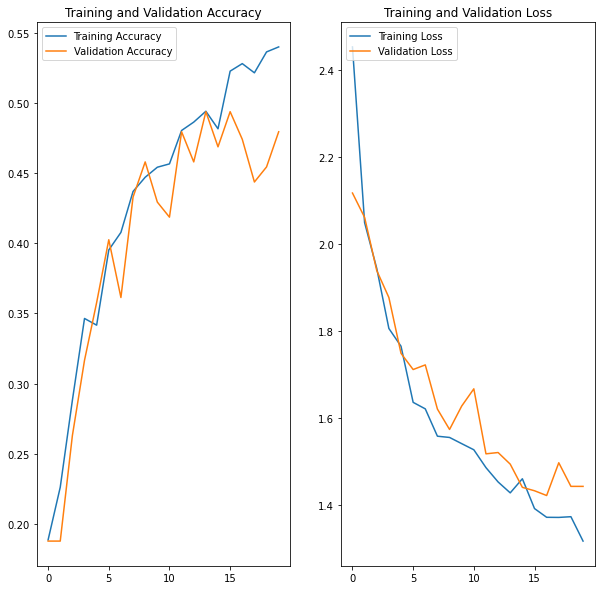

In [24]:
# Visualizing the Results
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(10,10))

# Accuracy Graph
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label= "Training Accuracy")
plt.plot(epochs_range, val_acc, label= "Validation Accuracy")
plt.legend(loc= "upper left")
plt.title("Training and Validation Accuracy")

# Loss Graph
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label= "Training Loss")
plt.plot(epochs_range, val_loss, label= "Validation Loss")
plt.legend(loc= "upper left")
plt.title("Training and Validation Loss")

plt.show()

`Inference:`
- We can observe that training accuracy is a bit closer to the validation accuracy as compared to the previous model run.
- This implies that there are other issues hindering the performance

In [25]:
# Checking for imbalance in the dataset
path_list = [str(x).split("\\")[-2:] for x in data_dir_train.glob("*/*")]
pd.DataFrame(path_list)[0].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: 0, dtype: int64

`Inference:`
- We can see that top 4 classes, i.e., pigmented benign keratosis, melanoma, basal cell carcinoma and nevus dominate the data in terms of proportions.
- seborrheic keratosis has the least of samples.

In [26]:
# We are adding 500 samples per class to make sure that none of the classes are sparse.

path_to_training_dataset=os.getcwd()+r'\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\'

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to C:\Users\jaiah\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21C04B31BB0>: 100%|█| 500/500 [00:02<00:00, 227.38 Samples


Initialised with 376 image(s) found.
Output directory set to C:\Users\jaiah\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21C04D838E0>: 100%|█| 500/500 [00:02<00:


Initialised with 95 image(s) found.
Output directory set to C:\Users\jaiah\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\dermatofibroma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21C04D850D0>: 100%|█| 500/500 [00:02<00:


Initialised with 438 image(s) found.
Output directory set to C:\Users\jaiah\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x21C04D8A0A0>: 100%|█| 500/500 [00:11<00:00, 45.02 Samples


Initialised with 357 image(s) found.
Output directory set to C:\Users\jaiah\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\nevus\output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x21C79233910>: 100%|█| 500/500 [00:10<00:00, 49.97 Samples/


Initialised with 462 image(s) found.
Output directory set to C:\Users\jaiah\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21C04BDBD30>: 100%|█| 500/500 [00:02<00:


Initialised with 77 image(s) found.
Output directory set to C:\Users\jaiah\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x21C792CF760>: 100%|█| 500/500 [00:04<00:00, 101.28 Sample


Initialised with 181 image(s) found.
Output directory set to C:\Users\jaiah\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\squamous cell carcinoma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x21C056BD3D0>: 100%|█| 500/500 [00:02<00:00, 225.39 Samples


Initialised with 139 image(s) found.
Output directory set to C:\Users\jaiah\\Skin cancer ISIC The International Skin Imaging Collaboration\\Train\\vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x21C04B410A0>: 100%|█| 500/500 [00:02<00:


In [27]:
# Augmentor has stored the augmented images in the output sub-directory of each of sub-directories of skin cancer types.
image_count_train = len(list(data_dir_train.glob("*/output/*.jpg")))
print(image_count_train)

4500


In [28]:
# Original Class Distribution

path_list = [x for x in glob(os.path.join(data_dir_train, '*/*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in data_dir_train.glob('*/*.jpg')]
dataframe_dict = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict.items()), columns = ['Path', 'Label'])
original_df['Label'].value_counts()

pigmented benign keratosis    462
melanoma                      438
basal cell carcinoma          376
nevus                         357
squamous cell carcinoma       181
vascular lesion               139
actinic keratosis             114
dermatofibroma                 95
seborrheic keratosis           77
Name: Label, dtype: int64

In [29]:
# New Class Distribution

new_path_list = [x for x in glob(os.path.join(data_dir_train, "*", "output", "*.jpg"))]
new_lesion_list = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, "*","output","*.jpg"))]
new_dataframe_dict = dict(zip(new_path_list, new_lesion_list))
df2 = pd.DataFrame(list(new_dataframe_dict.items()), columns = ["Path", "Label"])
new_df = original_df.append(df2)
new_df["Label"].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to mainatin some class balance.

In [30]:
batch_size = 32
img_height = 180
img_width = 180

In [31]:
# Creating a Training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed= 123,
    validation_split= 0.25,
    subset= "training",
    image_size= (img_height, img_width),
    batch_size= batch_size)

Found 6739 files belonging to 9 classes.
Using 5055 files for training.


In [32]:
# Creating a Validation set
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed= 123,
    validation_split= 0.25,
    subset= "validation",
    image_size= (img_height, img_width),
    batch_size= batch_size)

Found 6739 files belonging to 9 classes.
Using 1684 files for validation.


### Final Model

In [33]:
# Model
mod = Sequential()

# Rescaling the layer to normalize pixel values between (0,1)
mod.add(preprocessing.Rescaling(1.0/225, input_shape = (img_height,img_width,3)))

# Convolutional Layer - 1
mod.add(Conv2D(16, kernel_size=(3,3), activation="relu"))
# Pooling Layer - 1
mod.add(MaxPooling2D(pool_size=(2,2)))
# Dropout Layer - 1
mod.add(Dropout(0.25))

# Convolutional Layer - 2
mod.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
# Pooling Layer - 2
mod.add(MaxPooling2D(pool_size=(2,2)))
# Dropout Layer - 1
mod.add(Dropout(0.25))

# Convolutional Layer - 3
mod.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
# Pooling Layer - 3
mod.add(MaxPooling2D(pool_size=(2,2)))
# Dropout Layer - 1
mod.add(Dropout(0.25))

# Flattening and Putting fully connected layer
mod.add(Flatten())
mod.add(Dense(128, activation="relu"))

# Final Dropout Layer
mod.add(Dropout(0.30))

# Softmax Layer
mod.add(Dense(num_classes, activation="softmax"))

In [34]:
### Compiling the model
mod.compile(optimizer="adam",
           loss=tf.keras.losses.sparse_categorical_crossentropy,
           metrics=["accuracy"])

In [35]:
### Training the model
epochs = 50
history = mod.fit(train_ds,
                 validation_data=val_ds,
                 epochs=epochs)

Epoch 1/50
158/158 [==============================] - 49s 306ms/step - loss: 2.0820 - accuracy: 0.2087 - val_loss: 1.7943 - val_accuracy: 0.2904
Epoch 2/50
158/158 [==============================] - 49s 309ms/step - loss: 1.7086 - accuracy: 0.3379 - val_loss: 1.6445 - val_accuracy: 0.4086
Epoch 3/50
158/158 [==============================] - 48s 305ms/step - loss: 1.5129 - accuracy: 0.4265 - val_loss: 1.4137 - val_accuracy: 0.4751
Epoch 4/50
158/158 [==============================] - 49s 309ms/step - loss: 1.3950 - accuracy: 0.4684 - val_loss: 1.3196 - val_accuracy: 0.5089
Epoch 5/50
158/158 [==============================] - 48s 302ms/step - loss: 1.3004 - accuracy: 0.5001 - val_loss: 1.3084 - val_accuracy: 0.4923
Epoch 6/50
158/158 [==============================] - 49s 306ms/step - loss: 1.2536 - accuracy: 0.5179 - val_loss: 1.2011 - val_accuracy: 0.5534
Epoch 7/50
158/158 [==============================] - 48s 305ms/step - loss: 1.1634 - accuracy: 0.5573 - val_loss: 1.1111 - val_ac

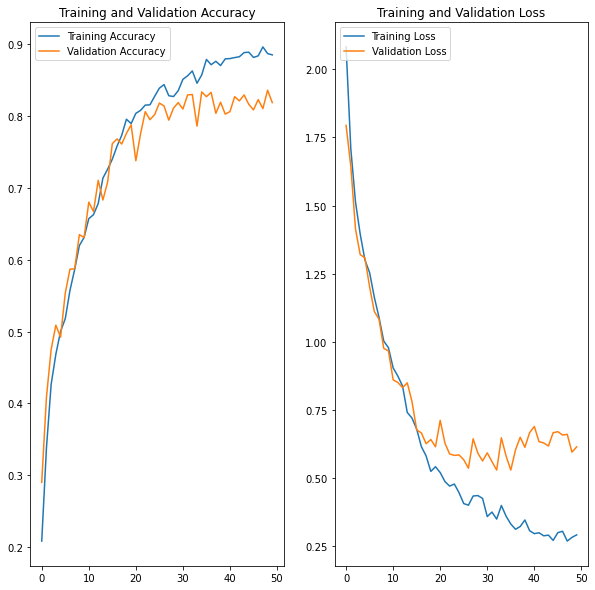

In [36]:
# Visualizing the results
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(10,10))

# Accuracy Graph
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label= "Training Accuracy")
plt.plot(epochs_range, val_acc, label= "Validation Accuracy")
plt.legend(loc= "upper left")
plt.title("Training and Validation Accuracy")

# Loss Graph
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label= "Training Loss")
plt.plot(epochs_range, val_loss, label= "Validation Loss")
plt.legend(loc= "upper left")
plt.title("Training and Validation Loss")

plt.show()

`Inference:`
- We can see that a good accuracy in the training as well as validation set.
- Since, the numbers are quite close, we can say that the model did not overfit.
- Hence, the final model using Dropouts and Class rebalancing helped.